In [24]:
import pandas as pd
import numpy as np
import re
import joblib
import pickle
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns

#load data
df = pd.read_csv('text_preprocessing/final_dataset.csv')
df

,Sentiment,tweet_tokens_stemmed
0,positive,"['undang', 'shanijkt', 'hitamputih', 'pemenang..."
1,positive,"['selamat', 'berbuka', 'puasa', 'semoga', 'ama..."
2,positive,"['trans', 'hitam', 'putih', 'penghargaan', 'no..."
3,positive,"['selamat', 'hitamputih']"
4,positive,"['asiknya', 'nonton', 'hitam', 'putih', 'trans']"
...,...,...
395,negative,"['banget', 'kesel', 'debat', 'pake', 'emosi', ..."
396,negative,"['miskin', 'miskin', 'sekolah', 'pungutan', 'l..."
397,negative,"['emosi', 'cepat', 'tua', 'nonton', 'emosi', '..."
398,negative,"['penampilan', 'kyk', 'preman', 'taunya', 'bki..."


In [25]:
#konversi sentimen positif =1 negatif= 0
def convert_label_sentimen(label_sentimen):
    if label_sentimen == "positive":
        return 1
    else:
        return 0

df['label_sentimen'] = df['Sentiment'].apply(convert_label_sentimen)
df.drop(df.columns[[0]], axis= 1,inplace=True)
df


,tweet_tokens_stemmed,label_sentimen
0,"['undang', 'shanijkt', 'hitamputih', 'pemenang...",1
1,"['selamat', 'berbuka', 'puasa', 'semoga', 'ama...",1
2,"['trans', 'hitam', 'putih', 'penghargaan', 'no...",1
3,"['selamat', 'hitamputih']",1
4,"['asiknya', 'nonton', 'hitam', 'putih', 'trans']",1
...,...,...
395,"['banget', 'kesel', 'debat', 'pake', 'emosi', ...",0
396,"['miskin', 'miskin', 'sekolah', 'pungutan', 'l...",0
397,"['emosi', 'cepat', 'tua', 'nonton', 'emosi', '...",0
398,"['penampilan', 'kyk', 'preman', 'taunya', 'bki...",0


In [26]:
X= df['tweet_tokens_stemmed'] 
y= df['label_sentimen']
#k-fold cross validation(spliting data)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


In [27]:
# Function to perform PSO feature selection
def pso_feature_selection(X_train, y_train, n_particles, n_iterations, num_features):
    num_samples, num_features = X_train.shape
    bounds = [0, 1]  # Assuming the feature selection is binary (selected or not)
    inertia = 0.8
    cognitive_weight = 1.5
    social_weight = 1.5

    # Initialize PSO
    num_particles = n_particles
    dimensions = num_features
    particles = np.random.rand(num_particles, dimensions)
    velocities = np.random.rand(num_particles, dimensions)
    best_positions = particles.copy()
    best_scores = np.zeros(num_particles)

    global_best_position = np.zeros(dimensions)
    global_best_score = 0

    for iteration in range(n_iterations):
        for particle in range(num_particles):
            # Evaluate fitness (accuracy) of current particle
            selected_features = particles[particle] > 0.5
            accuracy = evaluate_features(X_train, y_train, selected_features)

            # Update particle's best position and score
            if accuracy > best_scores[particle]:
                best_scores[particle] = accuracy
                best_positions[particle] = particles[particle].copy()

            # Update global best position and score
            if accuracy > global_best_score:
                global_best_score = accuracy
                global_best_position = particles[particle].copy()

            # Update particle's velocity
            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)
            velocities[particle] = (inertia * velocities[particle] +
                                   cognitive_weight * r1 * (best_positions[particle] - particles[particle]) +
                                   social_weight * r2 * (global_best_position - particles[particle]))

            # Update particle's position
            particles[particle] += velocities[particle]
            particles[particle] = np.clip(particles[particle], bounds[0], bounds[1])

    return global_best_position > 0.5

# Function to evaluate features using selected features and classifier
def evaluate_features(X_train, y_train, selected_features):
    X_selected = X_train[:, selected_features]
    clf = MultinomialNB()  # You can change the classifier here if needed
    cv_results = cross_val_score(clf, X_selected, y_train, cv=kfold, scoring='accuracy')
    return cv_results.mean()

MULTINOMIAL NAIVE BAYES

In [28]:
# Array penyimpan hasil K-10
cv_accuracy_mnb = []
cv_precision_mnb = []
cv_recall_mnb = []

In [29]:
for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # TF-IDF Vectorization
    tfidf_model = TfidfVectorizer(smooth_idf=False).fit(X_train)
    X_train_tfidf = tfidf_model.transform(X_train).toarray()
    X_test_tfidf = tfidf_model.transform(X_test).toarray()

    # Feature Selection using PSO
    selected_features = pso_feature_selection(X_train_tfidf, y_train, n_particles=20, n_iterations=100, num_features=X_train_tfidf.shape[1])


    # Train model using selected features
    mnb = MultinomialNB()
    mnb.fit(X_train_tfidf[:, selected_features], y_train)

    # Predictions
    predict_mnb = mnb.predict(X_test_tfidf[:, selected_features])

    # Evaluation
    accuracy_mnb = accuracy_score(y_test, predict_mnb)
    precision_mnb = precision_score(y_test, predict_mnb)
    recall_mnb = recall_score(y_test, predict_mnb)

    cv_accuracy_mnb.append(accuracy_mnb)
    cv_precision_mnb.append(precision_mnb)
    cv_recall_mnb.append(recall_mnb)

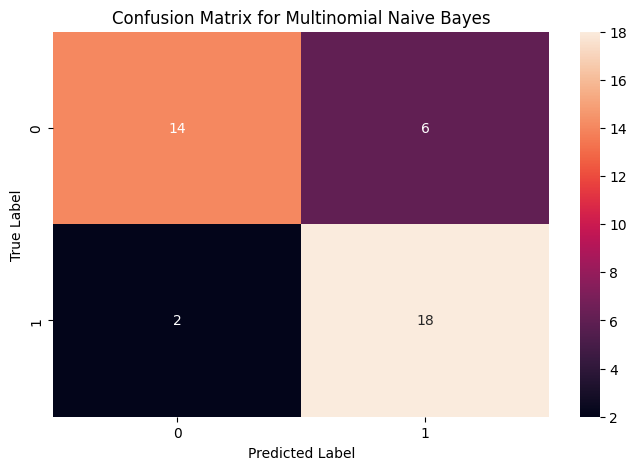

In [30]:
# confusion matrix model MultinomialNB
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, predict_mnb), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Multinomial Naive Bayes")
plt.show()

In [31]:
# Skor akurasi model
mean_accuracy_mnb = np.mean(cv_accuracy_mnb)
mean_precision_mnb = np.mean(cv_precision_mnb)
mean_recall_mnb = np.mean(cv_recall_mnb)

print("Multinomial Naive Bayes:")
print("Mean Accuracy:", mean_accuracy_mnb)
print("Mean Precision:", mean_precision_mnb)
print("Mean Recall:", mean_recall_mnb)

Multinomial Naive Bayes:
Mean Accuracy: 0.7875
Mean Precision: 0.7647117354211175
Mean Recall: 0.835


BERNOULLI NAIVE BAYES

In [32]:
# Array penyimpanan hasil k-10
cv_accuracy_bnb = []
cv_precision_bnb = []
cv_recall_bnb = []

In [33]:
for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # TF-IDF Vectorization
    tfidf_model = TfidfVectorizer(smooth_idf=False).fit(X_train)
    X_train_tfidf = tfidf_model.transform(X_train).toarray()
    X_test_tfidf = tfidf_model.transform(X_test).toarray()

    # Feature Selection using PSO
    selected_features = pso_feature_selection(X_train_tfidf, y_train, n_particles=30, n_iterations=80, num_features=X_train_tfidf.shape[1])


    # Train model using selected features
    bnb = BernoulliNB()
    bnb.fit(X_train_tfidf[:, selected_features], y_train)

    # Predictions
    predict_bnb = bnb.predict(X_test_tfidf[:, selected_features])

    # Evaluation
    accuracy_bnb = accuracy_score(y_test, predict_bnb)
    precision_bnb = precision_score(y_test, predict_bnb)
    recall_bnb = recall_score(y_test, predict_bnb)

    cv_accuracy_bnb.append(accuracy_bnb)
    cv_precision_bnb.append(precision_bnb)
    cv_recall_bnb.append(recall_bnb)

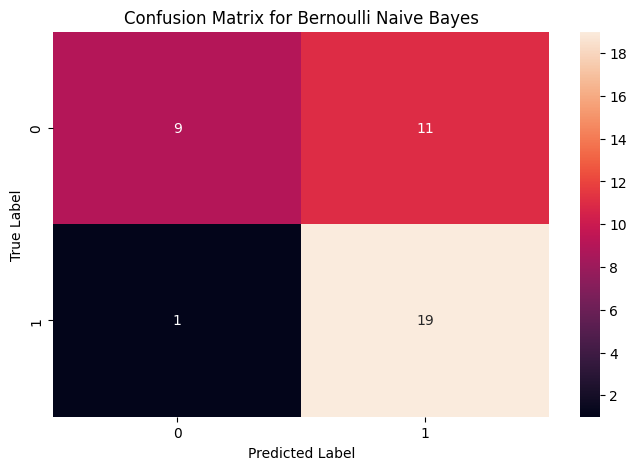

In [34]:
# confusion matrix model BernoulliNB
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, predict_bnb), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Bernoulli Naive Bayes")
plt.show()

In [35]:
mean_accuracy_bnb = np.mean(cv_accuracy_bnb)
mean_precision_bnb = np.mean(cv_precision_bnb)
mean_recall_bnb = np.mean(cv_recall_bnb)

print("Bernouilli Naive Bayes:")
print("Mean Accuracy:", mean_accuracy_bnb)
print("Mean Precision:", mean_precision_bnb)
print("Mean Recall:", mean_recall_bnb)

Bernouilli Naive Bayes:
Mean Accuracy: 0.775
Mean Precision: 0.7596812664459722
Mean Recall: 0.86


GAUSSIAN NAIVE BAYES

In [36]:
# Array penyimpanan hasil k-10
cv_accuracy_gnb = []
cv_precision_gnb = []
cv_recall_gnb = []

In [37]:
for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # TF-IDF Vectorization
    tfidf_model = TfidfVectorizer(smooth_idf=False).fit(X_train)
    X_train_tfidf = tfidf_model.transform(X_train).toarray()
    X_test_tfidf = tfidf_model.transform(X_test).toarray()

    # Feature Selection using PSO
    selected_features = pso_feature_selection(X_train_tfidf, y_train, n_particles=10, n_iterations=80, num_features=X_train_tfidf.shape[1])


    # Train model using selected features
    gnb = GaussianNB()
    gnb.fit(X_train_tfidf[:, selected_features], y_train)

    # Predictions
    predict_gnb = gnb.predict(X_test_tfidf[:, selected_features])

    # Evaluation
    accuracy_gnb = accuracy_score(y_test, predict_gnb)
    precision_gnb = precision_score(y_test, predict_gnb)
    recall_gnb = recall_score(y_test, predict_gnb)

    cv_accuracy_gnb.append(accuracy_gnb)
    cv_precision_gnb.append(precision_gnb)
    cv_recall_gnb.append(recall_gnb)

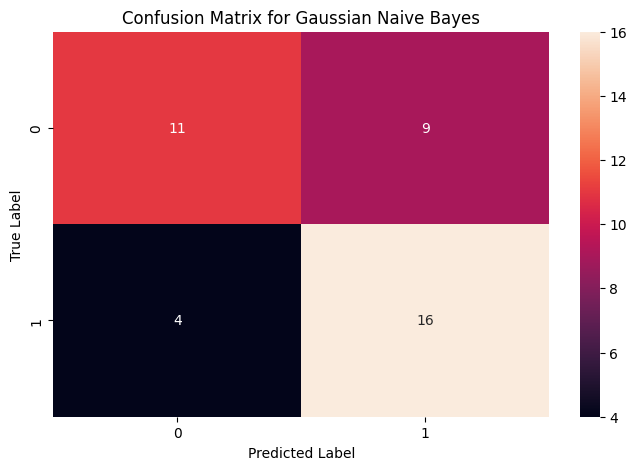

In [38]:
# confusion matrix model GaussianNB
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, predict_gnb), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Gaussian Naive Bayes")
plt.show()

In [39]:

mean_accuracy_gnb = np.mean(cv_accuracy_gnb)
mean_precision_gnb = np.mean(cv_precision_gnb)
mean_recall_gnb = np.mean(cv_recall_gnb)

print("Gaussian Naive Bayes:")
print("Mean Accuracy:", mean_accuracy_gnb)
print("Mean Precision:", mean_precision_gnb)
print("Mean Recall:", mean_recall_gnb)

Gaussian Naive Bayes:
Mean Accuracy: 0.6975
Mean Precision: 0.6553848158338412
Mean Recall: 0.835


TABEL HASIL KESELURUHAN

In [40]:
# Menyimpan hasil evaluasi dalam DataFrame
results_data = {
    'Model': ['Multinomial NB', 'Bernoulli NB', 'Gaussian NB'],
    'Mean Accuracy': [mean_accuracy_mnb, mean_accuracy_bnb, mean_accuracy_gnb],
    'Mean Precision': [mean_precision_mnb, mean_precision_bnb, mean_precision_gnb],
    'Mean Recall': [mean_recall_mnb, mean_recall_bnb, mean_recall_gnb]
}

results_df = pd.DataFrame(results_data)

# Menampilkan hasil dalam satu tabel
print(results_df)

            Model  Mean Accuracy  Mean Precision  Mean Recall
0  Multinomial NB         0.7875        0.764712        0.835
1    Bernoulli NB         0.7750        0.759681        0.860
2     Gaussian NB         0.6975        0.655385        0.835
